# Imports

In [2]:
import os
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report

In [3]:
!pip install -Uqq ipdb
import ipdb

# Setting seed and global variables

In [4]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seed set as {seed}")

set_seed()

Random seed set as 42


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
folder_path = "./drive/MyDrive/ColabData/SSL-polishing/"

# Load Data

In [6]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

In [7]:
train_data = torchvision.datasets.MNIST(
    root="MNIST",
    train=True,
    download=True,
    transform=transform
)

test_data = torchvision.datasets.MNIST(
    root="MNIST",
    train=False,
    download=True,
    transform=transform
)

In [8]:
def show(imgs):
    grid = torchvision.utils.make_grid(imgs)
    len_images = int(np.sqrt(len(grid)))
    for i, img in enumerate(grid):
        img = img.detach()
        img = 0.3081 * img + 0.1307 # denorm images
        img = torchvision.transforms.functional.to_pil_image(img)
        ax = plt.subplot(len_images, len_images, i+1)
        ax.axis('off')
        ax.imshow(np.asarray(img), cmap="gray")

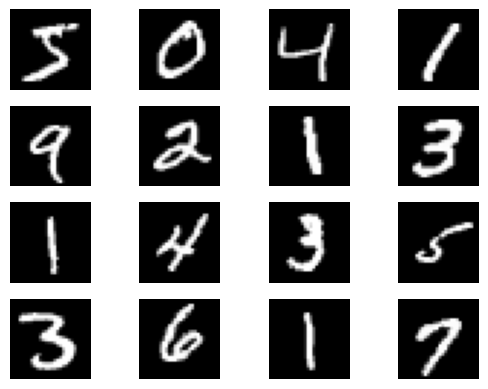

In [9]:
imgs = []
for i in range(16):
    img = train_data[i][0].squeeze()
    imgs.append(img)

show(imgs)

# Define Loss

In [10]:
def _l2_normalize(d):
    d_reshaped = d.view(d.shape[0], -1, *(1 for _ in range(d.dim() - 2)))
    d /= torch.norm(d_reshaped, dim=1, keepdim=True) + 1e-8
    return d

In [11]:
class VATLoss(nn.Module):

    def __init__(self, xi, eps, power_iterations=1):
        super(VATLoss, self).__init__()
        self.xi = xi
        self.eps = eps
        self.power_iterations = power_iterations

    def forward(self, model, x):
        model.eval()
        with torch.no_grad():
            pred = model(x)
            # pred = F.softmax(pred, dim=1)

        # prepare random unit tensor
        d = torch.rand(x.shape).sub(0.5).to(x.device)
        d = _l2_normalize(d)

        # calc adversarial direction
        for _ in range(self.power_iterations):
            d.requires_grad_()
            pred_hat = model(x + self.xi * d)
            logp_hat = F.log_softmax(pred_hat, dim=1)
            adv_distance = F.kl_div(logp_hat, pred, reduction='batchmean')
            adv_distance.backward()
            d = _l2_normalize(d.grad)
            model.zero_grad()

        # calc LDS
        r_adv = d * self.eps
        pred_hat = model(x + r_adv)
        logp_hat = F.log_softmax(pred_hat, dim=1)
        model.train()
        lds = F.kl_div(logp_hat, pred, reduction='batchmean')

        return lds

In [12]:
class VADLoss(nn.Module):
    def __init__(self, delta):
        super(VADLoss, self).__init__()
        self.delta = delta


    def forward(self, model, x):
        model.eval()
        with torch.no_grad():
            logit = model(x)
            # logit_p = F.softmax(logit_p, dim=1)

        adv_mask = self.generate_virtual_adversarial_dropout_mask(x, model, logit)
        logit_m = model(x, adv_mask)
        logit_p = F.log_softmax(logit, dim=1)

        model.train()
        loss = F.kl_div(logit_p, logit_m, reduction='batchmean')
        return loss


    def generate_virtual_adversarial_dropout_mask(self, x, model, logit):
        init_mask = torch.randint(0, 2, size=(x.shape[0], model.dropout_mask)).float().to(device)
        init_mask.requires_grad_()

        out = model(x, init_mask)
        logit_p = F.log_softmax(out, dim=1)

        dist = F.kl_div(logit_p, logit, reduction='batchmean')
        dist.backward()
        mask_grad = init_mask.grad
        model.zero_grad()

        # mask_grad = torch.autograd.grad(dist, initital_mask, create_graph=True)[0]
        return self.find_adversarial_dropout_condition(init_mask, mask_grad)

    def find_adversarial_dropout_condition(self, init_mask, jacobian):
        init_mask_f, jacobian_f = init_mask.flatten(), jacobian.flatten()
        H = init_mask.shape[1]
        _, sorted_indices = torch.sort(torch.abs(jacobian_f)) # Sorting absolute values of the Jacobian

        adv = init_mask_f.clone()

        d = 0
        while torch.norm(init_mask_f - adv, p=2) <= self.delta * H and d < H:
            id = sorted_indices[d]

            if adv[id] == 0 and jacobian_f[id] > 0:
                adv[id] = 1
            elif adv[id] == 1 and jacobian_f[id] < 0:
                adv[id] = 0

            d += 1

        return torch.reshape(adv, init_mask.shape)

In [13]:
class ContractiveLoss(nn.Module):
    def __init__(self):
        super(ContractiveLoss, self).__init__()

    def forward(self, x, recons, model):
        x.requires_grad_(True)
        encoded = model.encoder(x)
        jacobian = torch.autograd.grad(encoded, x, torch.ones_like(encoded), create_graph=True)[0]
        penalty = torch.sum(jacobian**2)
        mse_loss = F.mse_loss(recons, x)
        return mse_loss + 1e-3 * penalty

# Define Training Loop

## Data utils

In [14]:
def split_dataset(dataset, proportion):
    first_part = int(len(dataset) * proportion)
    second_part = len(dataset) - first_part

    first_dataset, second_dataset = torch.utils.data.random_split(dataset, [first_part, second_part])
    return first_dataset, second_dataset

In [15]:
def prepare_data(train_dataset, batch_size=100, labeled_data=1000):
    # Split into train and validation
    # train, validation = torch.utils.data.random_split(train_dataset, [len(train_dataset) - 1000, 1000])

    # Split into labeled and unlabeled
    validation, labeled_train, unlabeled_train = torch.utils.data.random_split(train_dataset, [1000, labeled_data, int(len(train_dataset) - labeled_data - 1000)])

    # Create dataloaders so that amount of batches is the same for unlabeled and labeled data
    supervised_split = labeled_data / int(len(train_dataset) - 1000)
    unlabeled_batch_size = int(batch_size * (1 - supervised_split) / supervised_split)

    labeled_loader = DataLoader(labeled_train, batch_size=batch_size, shuffle=True)
    unlabeled_loader = DataLoader(unlabeled_train, batch_size=unlabeled_batch_size, shuffle=True)
    val_loader = DataLoader(validation, batch_size=batch_size, shuffle=True)

    print(f"Labeled data {len(labeled_train)}. Unlabeled data {len(unlabeled_train)}. Validation data {len(validation)}")

    return labeled_loader, unlabeled_loader, val_loader

## Autoencoder training

In [16]:
def train_autoencoder(autoencoder, dataset, num_epochs, batch_size):
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    epoch_losses = []

    optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
    recons_loss = ContractiveLoss()

    for epoch in range(num_epochs):
        total_loss = 0.0

        for inputs, _ in train_loader:
            inputs = inputs.view(inputs.size(0), -1)
            inputs = inputs.to(device)

            optimizer.zero_grad()

            _, outputs = autoencoder(inputs)
            loss = recons_loss(inputs, outputs, autoencoder)

            loss.backward()
            optimizer.step()

            total_loss += loss.item() * inputs.size(0)

        epoch_loss = total_loss / len(train_loader.dataset)
        epoch_losses.append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
    return epoch_losses

## Classifier training

In [17]:
def training_phase(model, vat_loss, vad_loss, l_dataloader, ul_dataloader, autoencoder=None):
    running_loss, running_corrects, running_vat = 0.0, 0.0, 0.0

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    for labeled, unlabeled in zip(l_dataloader, ul_dataloader):
        inputs, labels, unl_inputs = labeled[0].to(device), labeled[1].to(device), unlabeled[0].to(device)

        if not autoencoder is None:
            autoencoder.eval()
            with torch.no_grad():
                inputs, _  = autoencoder(inputs)
                unl_inputs, _ = autoencoder(unl_inputs)

        model.train() # just in case

        optimizer.zero_grad()

        vat = vat_loss(model, torch.cat((inputs, unl_inputs), 0)) # we use both labeled and unlabeled data to udate VAT
        vad = vad_loss(model, torch.cat((inputs, unl_inputs), 0)) # we use both labeled and unlabeled data to udate VAD

        out_labels = model(inputs)
        preds = torch.max(out_labels, 1)[1]

        entropy = criterion(out_labels, labels)
        loss = entropy + vat + 0.2 * vad

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * (inputs.size(0) + unl_inputs.size(0))
        running_corrects += torch.sum(preds == labels)
        running_vat += vat.item()

    epoch_loss = running_loss / (len(l_dataloader.dataset) + len(ul_dataloader.dataset))
    epoch_acc = running_corrects.double() / len(l_dataloader.dataset)
    print(f"Training Phase Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")

    return epoch_loss, epoch_acc

In [18]:
def validation_phase(model, val_dataloader, autoencoder=None):
    running_loss, running_corrects = 0.0, 0.0
    criterion = nn.CrossEntropyLoss()

    model.eval()

    for inputs, labels in val_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        if not autoencoder is None:
            autoencoder.eval()
            with torch.no_grad():
                inputs, _ = autoencoder(inputs)

        with torch.no_grad():
            out_labels = model(inputs)
            preds = torch.max(out_labels, 1)[1]
            entropy = criterion(out_labels, labels)

        running_loss += entropy.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels)

    model.train()
    epoch_loss = running_loss / len(val_dataloader.dataset)
    epoch_acc = running_corrects.double() / len(val_dataloader.dataset)
    print(f"Validation Phase Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")

    return epoch_loss, epoch_acc

## Whole training loop

In [19]:
def train_semi_sup_model(classifier, train_dataset, supervised_split=0.016, batch_size=100, epochs=5, autoencoder=None):
    # Create datasets and split them

    labeled_loader, unlabeled_loader, val_loader = prepare_data(train_dataset, batch_size)

    vat_loss = VATLoss(xi=0.01, eps=10)
    vad_loss = VADLoss(delta=0.05)

    train_losses, train_accs, val_losses, val_accs = [], [], [], []

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        train_loss, train_acc = training_phase(classifier, vat_loss, vad_loss, labeled_loader, unlabeled_loader, autoencoder=autoencoder)
        val_loss, val_acc = validation_phase(classifier, val_loader, autoencoder=autoencoder)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

    return train_losses, train_accs, val_losses, val_accs

# Define model arhcitecture

In [20]:
class SemiSupervisedModel(nn.Module):
    def __init__(self, input_dim=784, dropout_mask=150, num_classes=10):
        super(SemiSupervisedModel, self).__init__()

        self.dropout_mask = dropout_mask

        self.fc = nn.Linear(input_dim, 1200)
        self.fc1 = nn.Linear(1200, 600)
        self.fc2 = nn.Linear(600, 300)
        self.fc3 = nn.Linear(300, dropout_mask)
        self.final_layer = nn.Linear(dropout_mask, num_classes)
        self.dropout = nn.Dropout(0.2)


    def forward(self, x, dropout_mask=None):
        # x = x.view(-1, 28*28)
        x = F.relu(self.fc(x))
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))

        if dropout_mask is None:
            dropout_mask = torch.ones_like(x) # Base dropout mask is 1 (Fully Connected)

        x = x * dropout_mask
        x = F.softmax(self.final_layer(x), dim=1)
        return x

In [21]:
class ContractiveAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(ContractiveAutoencoder, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1200),
            nn.ReLU(),
            nn.Linear(1200, hidden_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, 1200),
            nn.ReLU(),
            nn.Linear(1200,input_dim),
        )

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Train Model

In [22]:
autoencoder = ContractiveAutoencoder(784, 400).to(device)
autoencoder_res = train_autoencoder(autoencoder, train_data, 50, 100)

Epoch 1/50, Loss: 0.3371
Epoch 2/50, Loss: 0.1767
Epoch 3/50, Loss: 0.1377
Epoch 4/50, Loss: 0.1238
Epoch 5/50, Loss: 0.1156
Epoch 6/50, Loss: 0.1097
Epoch 7/50, Loss: 0.1052
Epoch 8/50, Loss: 0.1016
Epoch 9/50, Loss: 0.0987
Epoch 10/50, Loss: 0.0963
Epoch 11/50, Loss: 0.0943
Epoch 12/50, Loss: 0.0924
Epoch 13/50, Loss: 0.0910
Epoch 14/50, Loss: 0.0896
Epoch 15/50, Loss: 0.0883
Epoch 16/50, Loss: 0.0873
Epoch 17/50, Loss: 0.0863
Epoch 18/50, Loss: 0.0853
Epoch 19/50, Loss: 0.0846
Epoch 20/50, Loss: 0.0838
Epoch 21/50, Loss: 0.0831
Epoch 22/50, Loss: 0.0823
Epoch 23/50, Loss: 0.0818
Epoch 24/50, Loss: 0.0812
Epoch 25/50, Loss: 0.0805
Epoch 26/50, Loss: 0.0801
Epoch 27/50, Loss: 0.0796
Epoch 28/50, Loss: 0.0792
Epoch 29/50, Loss: 0.0787
Epoch 30/50, Loss: 0.0782
Epoch 31/50, Loss: 0.0777
Epoch 32/50, Loss: 0.0775
Epoch 33/50, Loss: 0.0770
Epoch 34/50, Loss: 0.0767
Epoch 35/50, Loss: 0.0762
Epoch 36/50, Loss: 0.0760
Epoch 37/50, Loss: 0.0757
Epoch 38/50, Loss: 0.0753
Epoch 39/50, Loss: 0.

In [26]:
model = SemiSupervisedModel(input_dim=400).to(device)
classifier_res = train_semi_sup_model(model, train_dataset=train_data, epochs=50, autoencoder=autoencoder)

Labeled data 1000. Unlabeled data 58000. Validation data 1000
Epoch 1/50
Training Phase Loss: 2.4543, Acc: 0.1540
Validation Phase Loss: 2.2707, Acc: 0.1210
Epoch 2/50
Training Phase Loss: 3.0203, Acc: 0.1210
Validation Phase Loss: 2.2633, Acc: 0.1210
Epoch 3/50
Training Phase Loss: 2.4630, Acc: 0.2690
Validation Phase Loss: 2.1145, Acc: 0.3560
Epoch 4/50
Training Phase Loss: 2.7648, Acc: 0.1940
Validation Phase Loss: 2.2307, Acc: 0.1340
Epoch 5/50
Training Phase Loss: 2.5820, Acc: 0.3020
Validation Phase Loss: 2.1063, Acc: 0.3510
Epoch 6/50
Training Phase Loss: 2.9006, Acc: 0.4570
Validation Phase Loss: 1.9874, Acc: 0.4870
Epoch 7/50
Training Phase Loss: 3.0374, Acc: 0.5430
Validation Phase Loss: 1.9593, Acc: 0.6020
Epoch 8/50
Training Phase Loss: 3.0788, Acc: 0.6070
Validation Phase Loss: 1.8788, Acc: 0.6120
Epoch 9/50
Training Phase Loss: 3.1693, Acc: 0.6540
Validation Phase Loss: 1.8729, Acc: 0.6370
Epoch 10/50
Training Phase Loss: 3.2079, Acc: 0.7130
Validation Phase Loss: 1.7973,

# Evaluate model

## Evaluate autoencoder

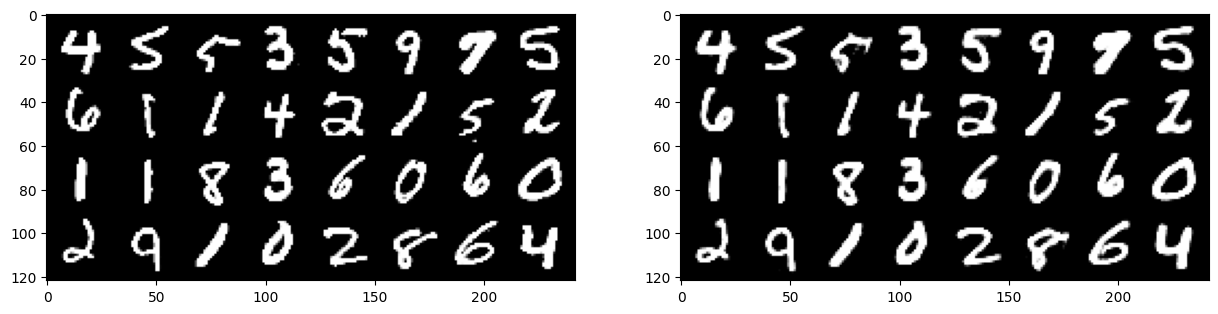

In [31]:
def convert_image_np(inp):
    inp = inp.cpu().detach().numpy().transpose(1, 2, 0)
    inp = np.clip(inp, 0, 1)
    return inp

def vizualize(inp, out):
    inp_grid = convert_image_np(torchvision.utils.make_grid(inp))
    out_grid = convert_image_np(torchvision.utils.make_grid(out))

    fig, ax = plt.subplots(1, 2)
    fig.set_figheight(15)
    fig.set_figwidth(15)
    ax[0].imshow(inp_grid)
    ax[1].imshow(out_grid)

batch_size=32
loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
inp, _ = next(iter(loader))
inp = inp.view(-1, autoencoder.input_dim)
inp = inp.to(device)
encoded, decoded = autoencoder(inp)
inp = inp.reshape(batch_size, 1, 28, 28)
decoded = decoded.reshape(batch_size, 1, 28, 28)
vizualize(inp, decoded)

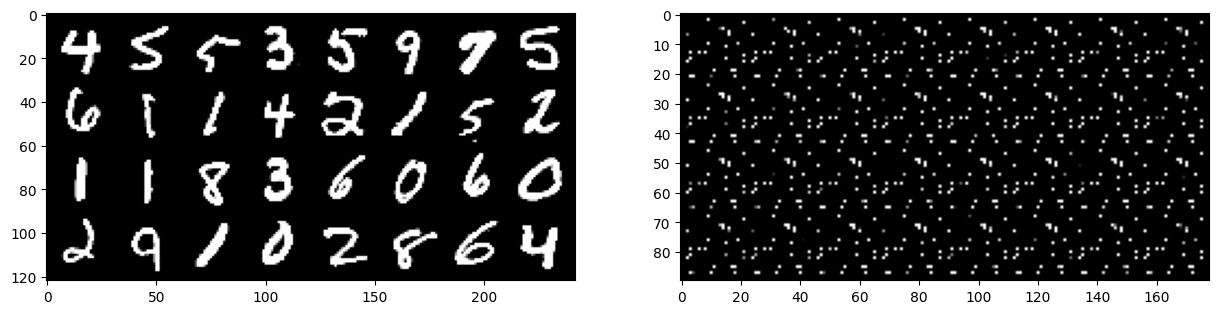

In [34]:
encoded_image = encoded.view(32, 20, 20).unsqueeze(1)
vizualize(inp, encoded_image)

## Evaluate classifier

In [29]:
def convert_tensor(tens):
    return tens.cpu().detach().numpy()

def evaluate_model(model, autoencoder, test_data):
    dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

    model.eval()
    autoencoder.eval()

    overall_targets = []
    overall_preds = []
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            inputs, _ = autoencoder(inputs)

            outputs = model(inputs)

            preds = torch.max(outputs, 1)[1]
            overall_targets.extend(convert_tensor(labels))
            overall_preds.extend(convert_tensor(preds))

    print(classification_report(overall_targets, overall_preds))
    return classification_report(overall_targets, overall_preds)

In [30]:
res = evaluate_model(model, autoencoder, test_data)

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       980
           1       0.95      0.99      0.97      1135
           2       0.92      0.92      0.92      1032
           3       0.84      0.96      0.90      1010
           4       0.96      0.92      0.94       982
           5       0.96      0.74      0.83       892
           6       0.95      0.95      0.95       958
           7       0.94      0.92      0.93      1028
           8       0.83      0.94      0.89       974
           9       0.94      0.91      0.93      1009

    accuracy                           0.92     10000
   macro avg       0.93      0.92      0.92     10000
weighted avg       0.93      0.92      0.92     10000

